<a href="https://colab.research.google.com/github/sunny0103/DeepLearning_nlp_projects/blob/main/korea_news_topics/korea_news_topics_classification_prompt_tunning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
cd "/content/drive/MyDrive/Data/KorNews_topic"

/content/drive/MyDrive/Data/KorNews_topic


In [3]:
!pip install evaluate tqdm datasets scikit-learn scipy peft

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 22.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.3/168.3 kB 23.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 18.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 21.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 32.5 MB/s eta 0:00:00


In [4]:
import argparse
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import random, os, gc
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.nn.utils.rnn import pad_sequence

from transformers import (AutoTokenizer,
                          AutoModelForSequenceClassification,
                          get_linear_schedule_with_warmup,
                          TrainingArguments,
                          Trainer,
                          DataCollatorWithPadding)
from datasets import Dataset
import evaluate

from peft import (get_peft_config,
                  get_peft_model,
                  get_peft_model_state_dict,
                  set_peft_model_state_dict,
                  PeftType,
                  PrefixTuningConfig,
                  PromptEncoderConfig,
                  PromptTuningConfig,
                )

import warnings
warnings.filterwarnings('ignore')


In [5]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)


seed_everything(42)
SEED = 42

In [6]:
data = pd.read_csv('./train_data.csv')
topic = pd.read_csv('./topic_dict.csv')
display(topic)
display(data.head())

,topic,topic_idx
0,IT과학,0
1,경제,1
2,사회,2
3,생활문화,3
4,세계,4
5,스포츠,5
6,정치,6


,index,title,topic_idx
0,0,인천→핀란드 항공기 결항…휴가철 여행객 분통,4
1,1,실리콘밸리 넘어서겠다…구글 15조원 들여 美전역 거점화,4
2,2,이란 외무 긴장완화 해결책은 미국이 경제전쟁 멈추는 것,4
3,3,NYT 클린턴 측근韓기업 특수관계 조명…공과 사 맞물려종합,4
4,4,시진핑 트럼프에 중미 무역협상 조속 타결 희망,4


In [7]:
id2label = topic.to_dict()['topic']
label2id = {label: id for id, label in id2label.items()}
print(id2label)
print(label2id)


{0: 'IT과학', 1: '경제', 2: '사회', 3: '생활문화', 4: '세계', 5: '스포츠', 6: '정치'}
{'IT과학': 0, '경제': 1, '사회': 2, '생활문화': 3, '세계': 4, '스포츠': 5, '정치': 6}


In [8]:
data.isnull().sum()

index        0
title        0
topic_idx    0
dtype: int64

In [9]:
X_train, X_valid, y_train, y_valid = train_test_split(data.index.values,
                                                    data.topic_idx.values,
                                                    test_size=0.2,
                                                    stratify=data.topic_idx.values,
                                                    random_state = SEED)

In [10]:
data['data_type'] =['not_set'] * data.shape[0]

data.loc[X_train, 'data_type'] = 'train'
data.loc[X_valid, 'data_type'] = 'valid'
data.head()

,index,title,topic_idx,data_type
0,0,인천→핀란드 항공기 결항…휴가철 여행객 분통,4,train
1,1,실리콘밸리 넘어서겠다…구글 15조원 들여 美전역 거점화,4,train
2,2,이란 외무 긴장완화 해결책은 미국이 경제전쟁 멈추는 것,4,train
3,3,NYT 클린턴 측근韓기업 특수관계 조명…공과 사 맞물려종합,4,train
4,4,시진핑 트럼프에 중미 무역협상 조속 타결 희망,4,valid


In [11]:
pd.DataFrame(data.groupby(['topic_idx', 'data_type'])['index'].count())

index
topic_idx data_type       
0         train       3859
          valid        965
1         train       4978
          valid       1244
2         train       5890
          valid       1472
3         train       4746
          valid       1187
4         train       6103
          valid       1526
5         train       5546
          valid       1387
6         train       5401
          valid       1350

In [12]:
# split train valid dataset
train_set = data[data.data_type == 'train']
valid_set = data[data.data_type == 'valid']

In [13]:
train_set = train_set.reset_index(drop=True)
valid_set = valid_set.reset_index(drop=True)

### Prompt Tunning
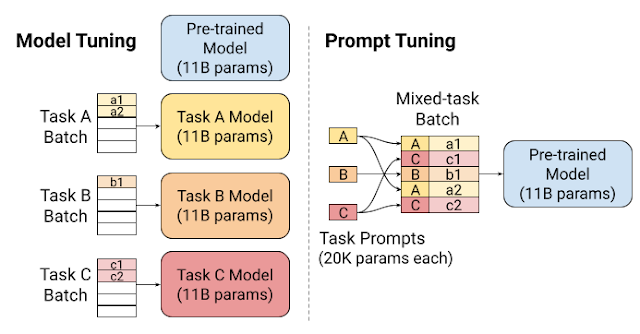

In [14]:
model_name_or_path = 'klue/roberta-large'
peft_type = PeftType.PROMPT_TUNING
device = 'cuda'

peft_config = PromptTuningConfig(task_type="SEQ_CLS",  num_virtual_tokens=20)

In [15]:
if any(k in model_name_or_path for k in ['gpt', 'opt', 'bloom']):
  padding_side = 'left'
else:
  padding_side = 'right'

tokenizer = AutoTokenizer.from_pretrained(model_name_or_path, padding_side=padding_side)
if getattr(tokenizer, 'pad_token_id') is None:
  tokenizer.pad_token_id = tokenizer.eos_token_id

tokenizer_config.json:   0%|          | 0.00/375 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/248k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/752k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/173 [00:00<?, ?B/s]

In [16]:
train_dataset = Dataset.from_pandas(train_set)
valid_dataset = Dataset.from_pandas(valid_set)
train_dataset

Dataset({
    features: ['index', 'title', 'topic_idx', 'data_type'],
    num_rows: 36523
})

In [17]:
def tokenize_function(examples):
  outputs = tokenizer(examples['title'], truncation=True, max_length=None)
  return outputs

In [18]:
tokenized_train = train_dataset.map(tokenize_function,
                                    batched=True,
                                    remove_columns =['index', 'title', 'data_type'])

tokenized_valid = valid_dataset.map(tokenize_function,
                                    batched=True,
                                    remove_columns =['index', 'title','data_type'])

tokenized_train = tokenized_train.rename_column("topic_idx", "labels")
tokenized_valid = tokenized_valid.rename_column("topic_idx", "labels")

Map:   0%|          | 0/36523 [00:00<?, ? examples/s]

Map:   0%|          | 0/9131 [00:00<?, ? examples/s]

In [19]:
tokenized_train

Dataset({
    features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 36523
})

In [20]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, padding="longest")

In [21]:
model = AutoModelForSequenceClassification.from_pretrained(model_name_or_path,
                                                           return_dict=True,
                                                           num_labels=len(id2label),
                                                           id2label=id2label,
                                                           label2id=label2id,)
model = get_peft_model(model, peft_config)
model.print_trainable_parameters()
model

config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.35G [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at klue/roberta-large and are newly initialized: ['classifier.out_proj.weight', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 1,077,255 || all params: 337,740,814 || trainable%: 0.3189590820373874


PeftModelForSequenceClassification(
  (base_model): RobertaForSequenceClassification(
    (roberta): RobertaModel(
      (embeddings): RobertaEmbeddings(
        (word_embeddings): Embedding(32000, 1024, padding_idx=1)
        (position_embeddings): Embedding(514, 1024, padding_idx=1)
        (token_type_embeddings): Embedding(1, 1024)
        (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): RobertaEncoder(
        (layer): ModuleList(
          (0-23): 24 x RobertaLayer(
            (attention): RobertaAttention(
              (self): RobertaSelfAttention(
                (query): Linear(in_features=1024, out_features=1024, bias=True)
                (key): Linear(in_features=1024, out_features=1024, bias=True)
                (value): Linear(in_features=1024, out_features=1024, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): RobertaS

In [22]:
metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
  predictions, labels = eval_pred
  predictions = np.argmax(predictions, axis=1)
  return metric.compute(predictions=predictions, references=labels)

In [23]:
model = model.to(device)


In [24]:
training_args = TrainingArguments(
    output_dir="./best_roberta_large_Prompt_tunning.model",
    learning_rate=1e-3,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=10,
    warmup_ratio=0.1,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_valid,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.538300,0.551143,0.826525
2,0.473700,0.416355,0.860913
3,0.445500,0.426484,0.853247
4,0.397600,0.361327,0.874384
5,0.383000,0.361294,0.873070
6,0.370200,0.366264,0.875479
7,0.356000,0.361301,0.873508
8,0.337700,0.344629,0.877341
9,0.328500,0.342252,0.878765
10,0.327200,0.342459,0.880517


TrainOutput(global_step=11420, training_loss=0.4238945849096295, metrics={'train_runtime': 1701.1925, 'train_samples_per_second': 214.691, 'train_steps_per_second': 6.713, 'total_flos': 1.4598420166043868e+16, 'train_loss': 0.4238945849096295, 'epoch': 10.0})